import cv2


In [2]:
# Import required modules
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline 

In [6]:
heads = {}
i = 0

folder_path = "AFLW2000-3D/AFLW2000/"
jpg_files = glob.glob(os.path.join(folder_path, "*.jpg"))
print(f"Found {len(jpg_files)} .jpg files in {folder_path}")

for image_path in jpg_files:
    image_name = os.path.basename(image_path)
    
    image = cv2.imread(os.path.join(folder_path, image_name))
    
    heads[image_name] = {
        "im_bgr": image,
        "im_rgb": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        "im_gray": cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    }
    
    # output_path = f"{image_name[0:-4]}_head_pose.jpg"  # Save annotated image for each
    print(f"\nProcessing {image_name}...")
    # result = GetHeadPose(image_path, output_path)
    # print("Head Pose Euler Angles:", result['angles'])
    # print("Rotation Matrix (Camera to Head Frame):\n", result['camera_to_head_rotation'])
    i = i + 1
    if i >= 30:
        break

Found 2000 .jpg files in AFLW2000-3D/AFLW2000/

Processing image00002.jpg...

Processing image00004.jpg...

Processing image00006.jpg...

Processing image00008.jpg...

Processing image00010.jpg...

Processing image00013.jpg...

Processing image00014.jpg...

Processing image00019.jpg...

Processing image00020.jpg...

Processing image00021.jpg...

Processing image00022.jpg...

Processing image00023.jpg...

Processing image00026.jpg...

Processing image00028.jpg...

Processing image00032.jpg...

Processing image00035.jpg...

Processing image00036.jpg...

Processing image00039.jpg...

Processing image00040.jpg...

Processing image00041.jpg...

Processing image00042.jpg...

Processing image00043.jpg...

Processing image00044.jpg...

Processing image00045.jpg...

Processing image00046.jpg...

Processing image00047.jpg...

Processing image00048.jpg...

Processing image00049.jpg...

Processing image00050.jpg...

Processing image00051.jpg...


In [7]:
print(heads.keys())

dict_keys(['image00002.jpg', 'image00004.jpg', 'image00006.jpg', 'image00008.jpg', 'image00010.jpg', 'image00013.jpg', 'image00014.jpg', 'image00019.jpg', 'image00020.jpg', 'image00021.jpg', 'image00022.jpg', 'image00023.jpg', 'image00026.jpg', 'image00028.jpg', 'image00032.jpg', 'image00035.jpg', 'image00036.jpg', 'image00039.jpg', 'image00040.jpg', 'image00041.jpg', 'image00042.jpg', 'image00043.jpg', 'image00044.jpg', 'image00045.jpg', 'image00046.jpg', 'image00047.jpg', 'image00048.jpg', 'image00049.jpg', 'image00050.jpg', 'image00051.jpg'])


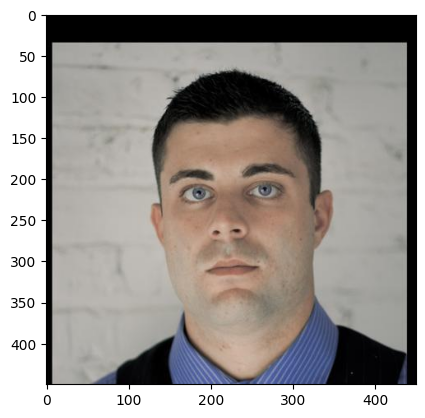

In [8]:
generic = heads["image00014.jpg"]
plt.imshow(generic["im_rgb"])

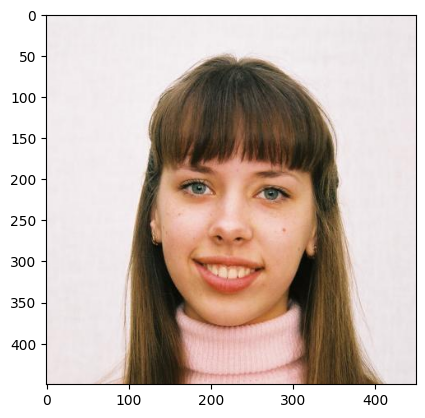

In [9]:
keys = heads.keys()
plt.imshow(heads[image_name]["im_rgb"])
unique = heads[image_name]

found 506 and 600 feature points ...


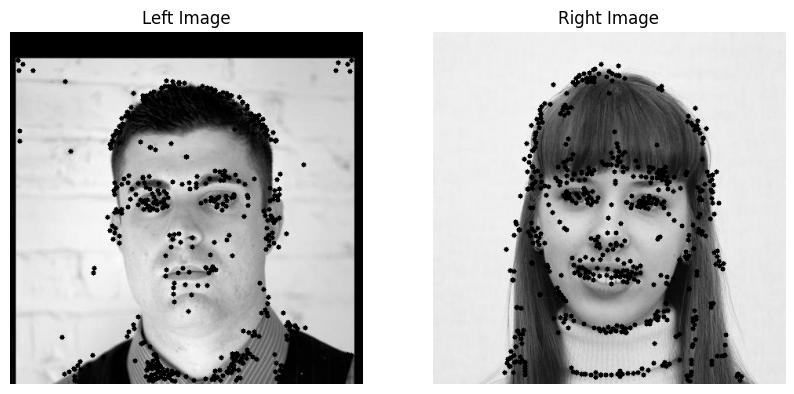

In [13]:
# Detect and describe features
num_features = 2000

sift = cv2.SIFT_create(nfeatures = num_features)
kp1, des1 = sift.detectAndCompute(generic["im_gray"], None)
kp2, des2 = sift.detectAndCompute(unique["im_gray"], None)
print('found %d and %d feature points ...'%(len(kp1),len(kp2)))


generic_gray = generic["im_gray"]
unique_gray = unique["im_gray"]

# draw located keypoints
imglc = cv2.cvtColor(generic_gray, cv2.COLOR_GRAY2RGB)
imgrc = cv2.cvtColor(unique_gray, cv2.COLOR_GRAY2RGB)
for k in kp1:
    cv2.circle(generic_gray,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)
for k in kp2:
    cv2.circle(unique_gray,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(generic_gray,'grey')
plt.title('Left Image')
plt.gca().set_axis_off()

plt.subplot(122)
plt.imshow(unique_gray,'grey')
plt.title('Right Image')
plt.gca().set_axis_off()

plt.show()

Found 186 matches ...


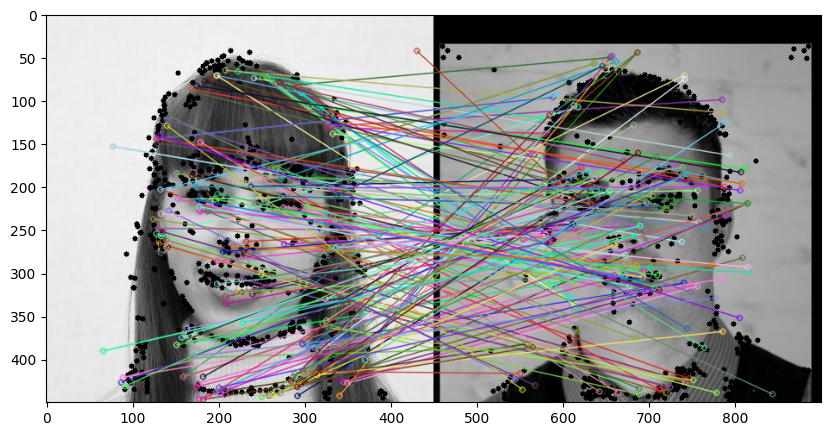

In [14]:
# initialise new matcher (cross-checker is used to only return matches that are the best in both views)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # for SIFT

# Perform matching using extracted descriptors
# Each "match" contains information about distance and the index from image 1 (queryIdx) and image 2 (trainIdx)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print('Found %d matches ...'%(len(matches)))

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(unique_gray,kp1,generic_gray,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

Found 18 inlier correspondances


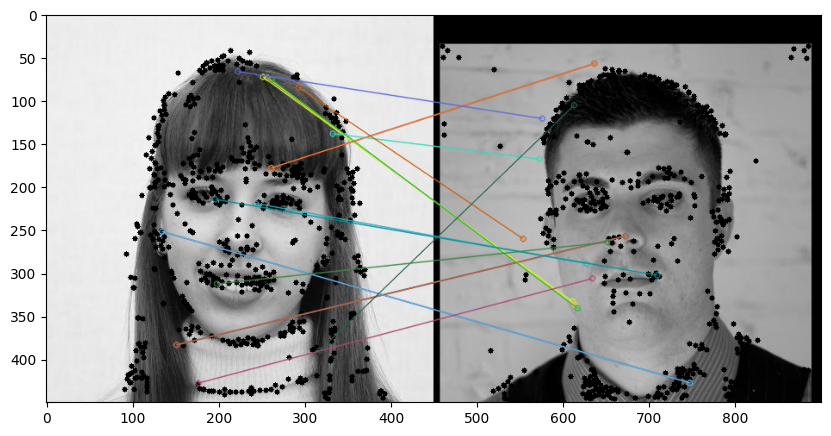

In [15]:
# compute Fundamental Matrix F between the two views using correspondances via RANSAC
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

# retain only points which were inliers (specified by "mask")
pts1_inliers = pts1[mask[:,0]==1]
pts2_inliers = pts2[mask[:,0]==1]

print("Found %d inlier correspondances"%(pts1_inliers.shape[0]))

# filter original matches list for re-drawing
matches_inliers = []
for i in range(mask.shape[0]):
    if mask[i,0] == 1:
        matches_inliers.append(matches[i])

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(unique_gray,kp1,generic_gray,kp2,matches_inliers,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

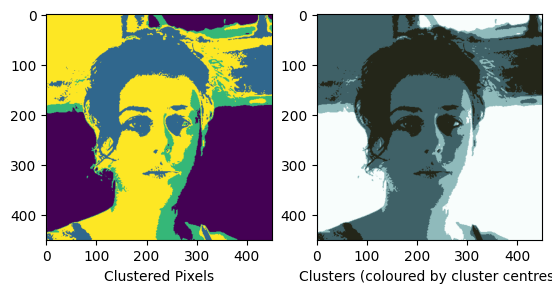

In [34]:
img = heads[image_name]["im_rgb"]

# Convert image pixel data (RGB) into 2D array
pixel_data = np.float32(img.reshape((-1,3)))

# K-means clustering
K = 4
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
(ret,labels,centers) = cv2.kmeans(pixel_data,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Reshape to create image with cluster IDs
label_img = labels.reshape((img.shape[:2]))

# Create image where colours correspond to the cluster center values (RGB) of corresponding cluster
centers = np.uint8(centers)
label_img2 = centers[labels.flatten()].reshape((img.shape))

plt.subplot(121)
plt.imshow(label_img) # apply standard colourmap to label numbers
plt.xlabel('Clustered Pixels')

plt.subplot(122)
plt.imshow(cv2.cvtColor(label_img2, cv2.COLOR_BGR2RGB))
plt.xlabel('Clusters (coloured by cluster centres)')

plt.show()